In [17]:
from PIL import Image, ImageDraw
import pytesseract
from pytesseract import Output
import numpy as np
import os
import cv2
import pytesseract

train_image_list = []
test_image_list = []
y_train_list = []
y_truth_list = []

# The below method would crop the individual words with the whole png file and create a new image file (.png)
# file for each word. pytesseract python library was used to do this activity. Please note, the task is to identify
# whose handwriting the image belongs to rather than identifying correct word within the image.
# The output .png file produced with each word would be like Mani_1.png, Mani_2.png etc. Here, label 'Mani' is used as
# as output of prediction once the model gets fitted.

def generate_text_images(image_path, j, image_name):
  # Load the image
  image = Image.open(image_path)

  # Perform OCR and get data including bounding boxes
  data = pytesseract.image_to_data(image, output_type=Output.DICT)  
  # Create a drawing object
  draw = ImageDraw.Draw(image)
  output_directory = '/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/'
  os.makedirs(output_directory, exist_ok=True)
  i=0  
  # Process the data
  for i in range(len(data['text'])):
    # Extract word bounding boxes
    word, x, y, w, h = data['text'][i], data['left'][i], data['top'][i], data['width'][i], data['height'][i]

    # Filter out non-word elements
    if word.strip() != '' and int(data['conf'][i]) > 0:
        # Crop and save the word as a separate image
        word_image = image.crop((x, y, x + w, y + h))
        word_image.save(f"{output_directory}{image_name}_{j}.png")
        if (j<=700):
          train_image = np.array(word_image)  
          train_image_list.append(train_image)
          y_train_list.append(image_name)  
        else:
          test_image = np.array(word_image) 
          test_image_list.append(test_image)
          y_truth_list.append(image_name)  
        j = j+1;
  return j

# The below code will feed the images to the method
j=1
for i in range(1,10):
  image_path = "/Users/manikanr/Documents/AI-Items/Handwriting-task/Handwritten_Mani_"+str(i)+".png"  
  j = generate_text_images(image_path, j, 'Mani')

j = 1 
for k in range(1,9): 
  image_path = "/Users/manikanr/Documents/AI-Items/Handwriting-task/Handwritten_Priya_"+str(k)+".png"  
  j = generate_text_images(image_path, j, 'Priya')
   
print("\nAll handwritten sentences in multiple images are transformed successfully into individual word images.")


All handwritten sentences in multiple images are transformed successfully into individual word images.


1400
326
(30, 66, 4)
(20, 72, 4)


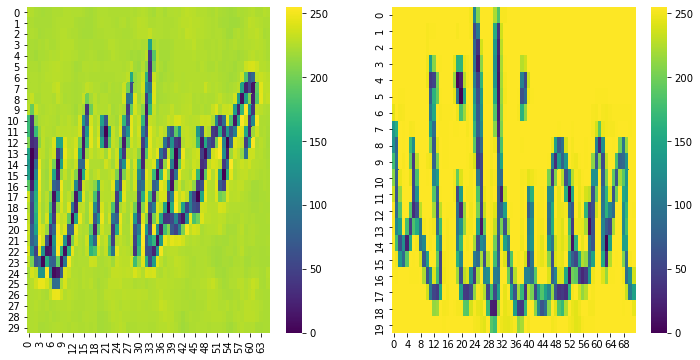

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(len(train_image_list))
print(len(test_image_list))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
image = Image.open('/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/Priya_6.png')
image_array = np.array(image)
print(image_array.shape)
channel = image_array[:, :, 0]
sns.heatmap(channel, cmap='viridis')

plt.subplot(1,2,2)
image = Image.open('/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/Mani_1.png')
image_array = np.array(image)
print(image_array.shape)
channel = image_array[:, :, 0]
sns.heatmap(channel, cmap='viridis')
plt.show()

In [21]:
# Convert the list of images to a numpy array
train_image_array = np.array(train_image_list, dtype=object)
test_image_array = np.array(test_image_list, dtype=object)


In [22]:
# Assuming image_array is your list of 3D image arrays
train_flattened_images = []
test_flattened_images = []

for img in train_image_array:
    # Flatten each 3D image array into a 1D array
    flattened_img = img.reshape(-1)
    # Append the flattened image to the list
    train_flattened_images.append(flattened_img)

# Convert the list of flattened images to a NumPy array
train_flattened_images_array = np.array(train_flattened_images, dtype=object)
print("\nShape of train word image array:", train_flattened_images_array.shape)

for img in test_image_array:
    # Flatten each 3D image array into a 1D array
    flattened_img = img.reshape(-1)
    # Append the flattened image to the list
    test_flattened_images.append(flattened_img)

# Convert the list of flattened images to a NumPy array
test_flattened_images_array = np.array(test_flattened_images, dtype=object)
print("\nShape of test word image array:", test_flattened_images_array.shape)
print("\n")


Shape of train word image array: (1400,)

Shape of test word image array: (326,)




In [24]:
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to numerical labels
y_encoded = label_encoder.fit_transform(y_train_list)

clf = svm.SVC(gamma=0.01, C=100)

# Find the maximum shape among all elements in train_flattened_images_array
max_train_shape = max(sample.shape for sample in train_flattened_images_array)
max_test_shape = max(sample.shape for sample in test_flattened_images_array)
max_shape = max(max_train_shape, max_test_shape)

# Create a new list to store padded samples
padded_train_samples = []
padded_test_samples = []

# Pad each sample to match the maximum shape
for sample in train_flattened_images_array:
    pad_width = [(0, max_dim - sample_dim) for max_dim, sample_dim in zip(max_shape, sample.shape)]
    padded_sample = np.pad(sample, pad_width, mode='constant', constant_values=0)
    padded_train_samples.append(padded_sample)

# Convert the list of padded samples to a NumPy array
padded_array = np.array(padded_train_samples)

# Reshape the padded array to 2 dimensions
num_samples = padded_array.shape[0]
num_features = np.prod(max_shape)
padded_array_reshaped = padded_array.reshape(num_samples, num_features)

x = padded_array_reshaped

# Fit and transform the data
x_scaled = scaler.fit_transform(x)
y_encoded = np.array(y_encoded)
clf.fit(x_scaled,y_encoded)


padded_test_samples = []

# Find the maximum shape among all elements in train_flattened_images_array
#max_shape = max(sample.shape for sample in test_flattened_images_array)

# Pad each sample to match the maximum shape
for sample in test_flattened_images_array:
    pad_width = [(0, max_dim - sample_dim) for max_dim, sample_dim in zip(max_shape, sample.shape)]
    padded_sample = np.pad(sample, pad_width, mode='constant', constant_values=0)
    padded_test_samples.append(padded_sample)

# Convert the list of padded samples to a NumPy array
padded_array = np.array(padded_test_samples)

# Reshape the padded array to 2 dimensions
num_samples = padded_array.shape[0]
num_features = np.prod(max_shape)
padded_array_reshaped = padded_array.reshape(num_samples, num_features)

test_x = padded_array_reshaped

test_x_scaled = scaler.fit_transform(test_x)

predict_last_326 = clf.predict(test_x_scaled)
print("The values predicted for last 326 examples are {}".format(predict_last_326))

The values predicted for last 326 examples are [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0
 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0]


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

y_truth_encoded = label_encoder.fit_transform(y_truth_list)
# Calculate accuracy
accuracy = accuracy_score(y_truth_encoded, predict_last_326)
print("\nAccuracy of handwriting task using SVM:", accuracy)
print("\n")


Accuracy of handwriting task using SVM: 0.6779141104294478




In [10]:
from sklearn.metrics import classification_report

# Generate a classification report for svm
report = classification_report(y_truth_encoded, predict_last_326)

# Print the classification report
print("\nThe classification report using SVM for Handwriting task is below\n")
print(report)



The classification report using SVM for Handwriting task is below

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       203
           1       0.62      0.37      0.46       123

    accuracy                           0.68       326
   macro avg       0.66      0.62      0.62       326
weighted avg       0.67      0.68      0.65       326



In [11]:
# Handwriting recognition using Neural Networks

from sklearn.model_selection import train_test_split

# Function to extract the label from the file name
def get_label(file_name):
    return file_name.split('_')[0]  # Extract the label before the underscore

# Load and preprocess the image data
def load_image(file_path, target_size=(28, 28)):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    return image

# List all image files in the directory
image_dir = '/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/'
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]

# Extract labels from the file names
labels = [get_label(file.split('/')[-1]) for file in image_files]

# Split the data into training and testing sets
x_train_files, x_test_files, y_train, y_test = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Load and preprocess the training and testing images
x_train = np.array([load_image(file) for file in x_train_files])
x_test = np.array([load_image(file) for file in x_test_files])


In [12]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the model architecture with convolutional neural network
# The activation function used here is Relu
# The CNN below has 32 kernels of size 3x3. Also, input shape is grayscale size of 28*28 with 1 channel
# Max-pooling reduces the spatial dimensions of input. 
# Flatten flattens the output of the previous layer into a one-dimensional array.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), # Hidden layer with 128 units
    tf.keras.layers.Dense(2)  # Output layer with 2 units (one for each class, handwriting task is for 2 classes)
])

# Compile the model
# 1. 'adam' is a type of stochastic gradient descent (SGD) optimization algorithm that efficiently
# updates the parameters based on the gradient of loss function
# 2. The SparseCategoricalCrossentropy is the loss function used when the output classes are integers. Here 0 and
# 1 for 'Mani' and 'Priya' respectively.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train_encoded, epochs=10, validation_data=(x_test, y_test_encoded))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_encoded, verbose=2)
print('\nHandriting task test accuracy:', test_acc)

Epoch 1/10
44/44 [==============================] - 1s 15ms/step - loss: 0.6714 - accuracy: 0.6232 - val_loss: 0.6231 - val_accuracy: 0.5925
Epoch 2/10
44/44 [==============================] - 1s 13ms/step - loss: 0.5114 - accuracy: 0.7783 - val_loss: 0.3943 - val_accuracy: 0.8699
Epoch 3/10
44/44 [==============================] - 1s 14ms/step - loss: 0.3390 - accuracy: 0.8797 - val_loss: 0.3507 - val_accuracy: 0.8035
Epoch 4/10
44/44 [==============================] - 1s 15ms/step - loss: 0.2534 - accuracy: 0.9123 - val_loss: 0.2763 - val_accuracy: 0.8555
Epoch 5/10
44/44 [==============================] - 1s 15ms/step - loss: 0.1829 - accuracy: 0.9428 - val_loss: 0.1788 - val_accuracy: 0.9335
Epoch 6/10
44/44 [==============================] - 1s 16ms/step - loss: 0.1592 - accuracy: 0.9457 - val_loss: 0.1382 - val_accuracy: 0.9595
Epoch 7/10
44/44 [==============================] - 1s 18ms/step - loss: 0.1327 - accuracy: 0.9529 - val_loss: 0.1298 - val_accuracy: 0.9566
Epoch 8/10
44

In [ ]:

The below code shows is used to show prediction results of CNN Classifier using random image files


In [13]:
classes = ['Mani', 'Priya']
new_image_path = '/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/Mani_446.png'
new_image = load_image(new_image_path)
prediction = model.predict(np.array([new_image]))
predicted_label = np.argmax(prediction)
print('\nPredicted Handwriting belongs to:', classes[predicted_label])

1/1 [==============================] - 0s 71ms/step

Predicted Handwriting belongs to: Mani


In [16]:
new_image_path = '/Users/manikanr/Documents/AI-Items/Handwriting-task/word_images/Priya_386.png'
new_image = load_image(new_image_path)
prediction = model.predict(np.array([new_image]))
predicted_label = np.argmax(prediction)
print('\nPredicted Handwriting belongs to:', classes[predicted_label])

1/1 [==============================] - 0s 17ms/step

Predicted Handwriting belongs to: Priya
